# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle
import random

# import our ensemble stacking model here
from models.model_ensembles import EnsembleStacking

In [2]:
# for reproducecibility
random_state = 60251014
random.seed(random_state)

# Load Data After Preprocessing
***
Load data Breast Cancer Diagnosis and Breast Cancer Prognosis after cleaned and preprocessed

In [3]:
breast_cancer_preprocessed = pickle.load(open('../dataset/preprocessed_breast_cancer_data.pkl', 'rb'))

# diagnosis breast cancer dataset
# diagnosis_X_train_original = breast_cancer_preprocessed['diagnosis']['original']['X_train']
# diagnosis_X_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['X_train']
# diagnosis_X_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['X_train']

# diagnosis_y_train_original = breast_cancer_preprocessed['diagnosis']['original']['y_train']
# diagnosis_y_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['y_train']
# diagnosis_y_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['y_train']

# diagnosis_X_test_original = breast_cancer_preprocessed['diagnosis']['original']['X_test']
# diagnosis_y_test_original = breast_cancer_preprocessed['diagnosis']['original']['y_test']



# prognosis breast cancer dataset
prognosis_X_train_original = breast_cancer_preprocessed['prognosis']['original']['X_train']
prognosis_X_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['X_train']
prognosis_X_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['X_train']

prognosis_y_train_original = breast_cancer_preprocessed['prognosis']['original']['y_train']
prognosis_y_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['y_train']
prognosis_y_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['y_train']

prognosis_X_test_original = breast_cancer_preprocessed['prognosis']['original']['X_test']
prognosis_y_test_original = breast_cancer_preprocessed['prognosis']['original']['y_test']

# Defining Global Variables

In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
hidden_layer_sizes=(100,20)
max_iter=100
batch_size=64 
verbose=1
n_iter_no_change=20

# Defining Global Functions

In [5]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()
    list_of_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            list_of_models.append('majority_vote_from_'+model_name)
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features.columns = list_of_models
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [6]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

# <Do Your Hyperparameter Optimization Techniques Here (Grid Search or Genetic Algorithm!>

***
Find the best optimal hyperparameter from each model (SVM, DT, LR and also hyperparameter in ANN) and then build your model using the those best hyperparameter combination. <br>
You can customize Ensemble Classifiers codes in this folder or path: "models/model_ensembles.py"

# Modelling Ensemble Classifiers for Prognosis Breast Cancer Dataset

## Without Data Sampling Method (Original)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [7]:
ensemble_classifiers_prognosis_original = EnsembleStacking(
    prognosis_X_train_original, 
    prognosis_y_train_original, 
    prognosis_X_test_original, 
    prognosis_y_test_original, 
    kfold).train_ensemble()

In [8]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_prognosis_original = list()
for model in ensemble_classifiers_prognosis_original.keys():
    ensemble_classifiers_results_prognosis_original.append(pd.DataFrame(ensemble_classifiers_prognosis_original[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_prognosis_original = pd.concat(ensemble_classifiers_results_prognosis_original, axis=0)
ensemble_classifiers_results_prognosis_original

,train,training,validation,testing
model-1,SVC(),0.780488,0.774194,0.74359
model-2,SVC(),0.772358,0.774194,0.717949
model-3,SVC(),0.788618,0.774194,0.717949
model-4,SVC(),0.788618,0.774194,0.717949
model-5,SVC(),0.814516,0.766667,0.717949
model-3,LogisticRegression(solver='newton-cg'),0.796748,0.806452,0.794872
model-5,LogisticRegression(solver='newton-cg'),0.806452,0.7,0.794872
model-1,LogisticRegression(solver='newton-cg'),0.772358,0.806452,0.769231
model-2,LogisticRegression(solver='newton-cg'),0.780488,0.774194,0.769231
model-4,LogisticRegression(solver='newton-cg'),0.788618,0.774194,0.74359


### Create New Input Training from stacking ensemble ML

In [9]:
new_input_training_features_prognosis_original = create_new_input_features(
    ensemble_classifiers_prognosis_original, 
    prognosis_X_train_original,
    prognosis_y_train_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [10]:
new_input_training_features_prognosis_original.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,0,0,0,1,1
2,0,0,0,0,0
3,0,0,0,1,1
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [11]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_prognosis_original.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_prognosis_original['ground_truth']

# feed new X and new y into ANN
ann_model_prognosis_original = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=max_iter, 
    batch_size=batch_size, 
    verbose=verbose,
    n_iter_no_change=n_iter_no_change
)
ann_model_prognosis_original.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_original = ann_model_prognosis_original.predict(new_X_train)
predicted_ann_train_prognosis_original = ann_model_prognosis_original.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Original) = ", accuracy_score(new_y_train, predicted_ann_train_prognosis_original))

Iteration 1, loss = 0.72567737
Iteration 2, loss = 0.70252639
Iteration 3, loss = 0.67899073
Iteration 4, loss = 0.65939111
Iteration 5, loss = 0.63940071
Iteration 6, loss = 0.62031269
Iteration 7, loss = 0.60228340
Iteration 8, loss = 0.58432013
Iteration 9, loss = 0.56766237
Iteration 10, loss = 0.55373433
Iteration 11, loss = 0.54025634
Iteration 12, loss = 0.52648564
Iteration 13, loss = 0.51281109
Iteration 14, loss = 0.49856984
Iteration 15, loss = 0.48385317
Iteration 16, loss = 0.47068332
Iteration 17, loss = 0.45724080
Iteration 18, loss = 0.44349167
Iteration 19, loss = 0.42942778
Iteration 20, loss = 0.41434060
Iteration 21, loss = 0.39977723
Iteration 22, loss = 0.38436089
Iteration 23, loss = 0.36987396
Iteration 24, loss = 0.35515089
Iteration 25, loss = 0.34037843
Iteration 26, loss = 0.32593660
Iteration 27, loss = 0.31184324
Iteration 28, loss = 0.29762128
Iteration 29, loss = 0.28394428
Iteration 30, loss = 0.27029052
Iteration 31, loss = 0.25692522
Iteration 32, los

C:\Users\ASUS\anaconda3\envs\S2_computational_intelligence_final_project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


## With Data Sampling Method (Upsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [12]:
ensemble_classifiers_prognosis_upsampling = EnsembleStacking(
    prognosis_X_train_upsampling, 
    prognosis_y_train_upsampling, 
    prognosis_X_test_original, 
    prognosis_y_test_original, 
    kfold).train_ensemble()

In [13]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_prognosis_upsampling = list()
for model in ensemble_classifiers_prognosis_upsampling.keys():
    ensemble_classifiers_results_prognosis_upsampling.append(pd.DataFrame(ensemble_classifiers_prognosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_prognosis_upsampling = pd.concat(ensemble_classifiers_results_prognosis_upsampling, axis=0)
ensemble_classifiers_results_prognosis_upsampling

,train,training,validation,testing
model-1,SVC(),0.921053,0.75,0.74359
model-3,SVC(),0.894737,0.875,0.74359
model-2,SVC(),0.894737,0.791667,0.717949
model-5,SVC(),0.895288,0.829787,0.717949
model-4,SVC(),0.890052,0.808511,0.666667
model-2,LogisticRegression(solver='newton-cg'),0.721053,0.75,0.74359
model-5,LogisticRegression(solver='newton-cg'),0.748691,0.659574,0.74359
model-1,LogisticRegression(solver='newton-cg'),0.736842,0.604167,0.666667
model-3,LogisticRegression(solver='newton-cg'),0.705263,0.8125,0.666667
model-4,LogisticRegression(solver='newton-cg'),0.722513,0.680851,0.666667


### Create New Input Training from stacking ensemble ML

In [14]:
new_input_training_features_prognosis_upsampling = create_new_input_features(
    ensemble_classifiers_prognosis_upsampling, 
    prognosis_X_train_upsampling,
    prognosis_y_train_upsampling
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [15]:
new_input_training_features_prognosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,1,0,0
1,1,0,1,1,1
2,1,0,0,1,1
3,0,0,1,0,0
4,1,0,0,0,0


### Feed New Input Features into ANN Model

In [16]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_prognosis_upsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_prognosis_upsampling['ground_truth']

# feed new X and new y into ANN
ann_model_prognosis_upsampling = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=max_iter, 
    batch_size=batch_size, 
    verbose=verbose,
    n_iter_no_change=n_iter_no_change
)
ann_model_prognosis_upsampling.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_upsampling = ann_model_prognosis_upsampling.predict(new_X_train)
predicted_ann_train_prognosis_upsampling = ann_model_prognosis_upsampling.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_prognosis_upsampling))

Iteration 1, loss = 0.76842363
Iteration 2, loss = 0.72167352
Iteration 3, loss = 0.67569077
Iteration 4, loss = 0.63595266
Iteration 5, loss = 0.59898434
Iteration 6, loss = 0.56153152
Iteration 7, loss = 0.52661370
Iteration 8, loss = 0.49239797
Iteration 9, loss = 0.45974573
Iteration 10, loss = 0.42793869
Iteration 11, loss = 0.39602538
Iteration 12, loss = 0.36494171
Iteration 13, loss = 0.33469423
Iteration 14, loss = 0.30555808
Iteration 15, loss = 0.27743956
Iteration 16, loss = 0.25073355
Iteration 17, loss = 0.22555284
Iteration 18, loss = 0.20208360
Iteration 19, loss = 0.18055399
Iteration 20, loss = 0.16065056
Iteration 21, loss = 0.14236116
Iteration 22, loss = 0.12552529
Iteration 23, loss = 0.10994446
Iteration 24, loss = 0.09594365
Iteration 25, loss = 0.08396726
Iteration 26, loss = 0.07391659
Iteration 27, loss = 0.06532605
Iteration 28, loss = 0.05784086
Iteration 29, loss = 0.05146509
Iteration 30, loss = 0.04600925
Iteration 31, loss = 0.04132167
Iteration 32, los

## With Data Sampling Method (Downsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [17]:
ensemble_classifiers_prognosis_downsampling = EnsembleStacking(
    prognosis_X_train_downsampling, 
    prognosis_y_train_downsampling, 
    prognosis_X_test_original, 
    prognosis_y_test_original, 
    kfold).train_ensemble()

In [18]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_prognosis_downsampling = list()
for model in ensemble_classifiers_prognosis_downsampling.keys():
    ensemble_classifiers_results_prognosis_downsampling.append(pd.DataFrame(ensemble_classifiers_prognosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_prognosis_downsampling = pd.concat(ensemble_classifiers_results_prognosis_downsampling, axis=0)
ensemble_classifiers_results_prognosis_downsampling

,train,training,validation,testing
model-2,SVC(),0.910714,0.571429,0.692308
model-3,SVC(),0.892857,0.5,0.692308
model-1,SVC(),0.892857,0.5,0.641026
model-4,SVC(),0.875,0.5,0.641026
model-5,SVC(),0.892857,0.642857,0.512821
model-2,LogisticRegression(solver='newton-cg'),0.732143,0.571429,0.717949
model-3,LogisticRegression(solver='newton-cg'),0.803571,0.5,0.666667
model-4,LogisticRegression(solver='newton-cg'),0.767857,0.5,0.641026
model-1,LogisticRegression(solver='newton-cg'),0.75,0.571429,0.615385
model-5,LogisticRegression(solver='newton-cg'),0.767857,0.714286,0.564103


### Create New Input Training from stacking ensemble ML

In [19]:
new_input_training_features_prognosis_downsampling = create_new_input_features(
    ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_train_downsampling,
    prognosis_y_train_downsampling
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [20]:
new_input_training_features_prognosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,1,1,1,1,1
1,1,1,1,1,1
2,0,1,1,0,0
3,0,1,0,0,0
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [21]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_prognosis_downsampling['ground_truth']

# feed new X and new y into ANN
ann_model_prognosis_downsampling = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter=max_iter, 
    batch_size=batch_size, 
    verbose=verbose,
    n_iter_no_change=n_iter_no_change
)
ann_model_prognosis_downsampling.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_downsampling = ann_model_prognosis_downsampling.predict(new_X_train)
predicted_ann_train_prognosis_downsampling = ann_model_prognosis_downsampling.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Prognostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_prognosis_downsampling))

Iteration 1, loss = 0.84937019
Iteration 2, loss = 0.81455138
Iteration 3, loss = 0.78261967
Iteration 4, loss = 0.75326845
Iteration 5, loss = 0.72391103
Iteration 6, loss = 0.70042996
Iteration 7, loss = 0.67911983
Iteration 8, loss = 0.66103046
Iteration 9, loss = 0.64385604
Iteration 10, loss = 0.62996999
Iteration 11, loss = 0.61587830
Iteration 12, loss = 0.60181109
Iteration 13, loss = 0.58800302
Iteration 14, loss = 0.57543381
Iteration 15, loss = 0.56220712
Iteration 16, loss = 0.54903935
Iteration 17, loss = 0.53565405
Iteration 18, loss = 0.52178911
Iteration 19, loss = 0.50896276
Iteration 20, loss = 0.49641537
Iteration 21, loss = 0.48336242
Iteration 22, loss = 0.46970888
Iteration 23, loss = 0.45559573
Iteration 24, loss = 0.44205648
Iteration 25, loss = 0.42838063
Iteration 26, loss = 0.41442788
Iteration 27, loss = 0.40009475
Iteration 28, loss = 0.38608411
Iteration 29, loss = 0.37240631
Iteration 30, loss = 0.35898353
Iteration 31, loss = 0.34592770
Iteration 32, los

C:\Users\ASUS\anaconda3\envs\S2_computational_intelligence_final_project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


# Testing Results

## Without Data Sampling (Original)

### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [22]:
new_input_testing_features_prognosis_original = create_new_input_features(
    ensemble_classifiers_prognosis_original, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSTIC BREAST CANCER (ORIGINAL)
	Akurasi Score:  0.7948717948717948
	Macro Recall Score:  0.6915584415584416
	Macro Precision Score:  0.7633928571428572
	Macro F1-score Score:  0.711111111111111
	Macro F2-score Score:  0.6964869281045751
	Macro F0.5-score Score:  0.7371794871794872


              precision    recall  f1-score   support

           0       0.81      0.93      0.87        28
           1       0.71      0.45      0.56        11

    accuracy                           0.79        39
   macro avg       0.76      0.69      0.71        39
weighted avg       0.78      0.79      0.78        39



<Figure size 1008x576 with 0 Axes>

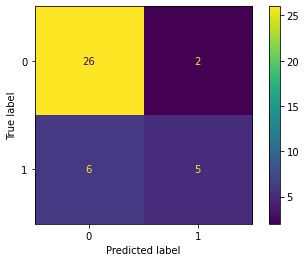

In [23]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_prognosis_original.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_prognosis_original['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_original = ann_model_prognosis_original.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognostic Breast Cancer (Original)', new_y_test, predicted_test_original)

## With Data Sampling Method (Upsampling)

### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [24]:
new_input_testing_features_prognosis_upsampling = create_new_input_features(
    ensemble_classifiers_prognosis_upsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSTIC BREAST CANCER (UPSAMPLING)
	Akurasi Score:  0.7692307692307693
	Macro Recall Score:  0.7288961038961039
	Macro Precision Score:  0.7175925925925926
	Macro F1-score Score:  0.7225296442687748
	Macro F2-score Score:  0.7261690647482015
	Macro F0.5-score Score:  0.7194042871385842


              precision    recall  f1-score   support

           0       0.85      0.82      0.84        28
           1       0.58      0.64      0.61        11

    accuracy                           0.77        39
   macro avg       0.72      0.73      0.72        39
weighted avg       0.78      0.77      0.77        39



<Figure size 1008x576 with 0 Axes>

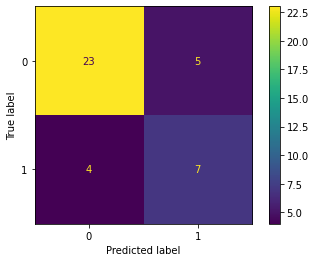

In [25]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_prognosis_upsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_prognosis_upsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_upsampling = ann_model_prognosis_upsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognostic Breast Cancer (Upsampling)', new_y_test, predicted_test_upsampling)

## With Data Sampling Method (Downsampling)

### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [26]:
new_input_testing_features_prognosis_downsampling = create_new_input_features(
    ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSTIC BREAST CANCER (DOWNSAMPLING)
	Akurasi Score:  0.7435897435897436
	Macro Recall Score:  0.7662337662337663
	Macro Precision Score:  0.7192513368983957
	Macro F1-score Score:  0.7214285714285714
	Macro F2-score Score:  0.7419867873746024
	Macro F0.5-score Score:  0.7158446093408991


              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.53      0.82      0.64        11

    accuracy                           0.74        39
   macro avg       0.72      0.77      0.72        39
weighted avg       0.80      0.74      0.76        39



<Figure size 1008x576 with 0 Axes>

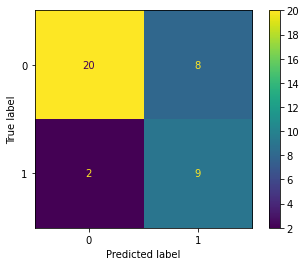

In [27]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_prognosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_downsampling = ann_model_prognosis_downsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognostic Breast Cancer (Downsampling)', new_y_test, predicted_test_downsampling)